*구글 로그인 후에 사용해주세요

구글 드라이브에 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Papago 번역 API 불러오기

In [96]:
import requests

def get_translate(text):
    client_id = "QI0fBM8K2nPjEQABj81U" # <-- client_id 기입
    client_secret = "AlThDQ4lDd" # <-- client_secret 기입

    data = {'text' : text,
            'source' : 'ko',
            'target': 'en'}

    url = "https://openapi.naver.com/v1/papago/n2mt"

    header = {"X-Naver-Client-Id":client_id,
              "X-Naver-Client-Secret":client_secret}

    response = requests.post(url, headers=header, data=data)
    rescode = response.status_code

    if(rescode==200):
        send_data = response.json()
        trans_data = (send_data['message']['result']['translatedText'])
        return trans_data
    else:
        print("Error Code:" , rescode)

GLIDE 생성자 불러오기

In [9]:
#install the package
!pip install git+https://github.com/openai/glide-text2im

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-gery8iit
  Running command git clone -q https://github.com/openai/glide-text2im /tmp/pip-req-build-gery8iit


기타 라이브러리 불러오기

In [42]:
from __future__ import print_function

from PIL import Image
from IPython.display import display
import os
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler,
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

GPU 사용 여부 확인

In [11]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')
print(device)

cuda


CLIP 데이터 셋 불러오기

In [12]:
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))

  0%|          | 0.00/346M [00:00<?, ?iB/s]

  0%|          | 0.00/287M [00:00<?, ?iB/s]

<All keys matched successfully>

사전학습 모델 불러오기(기본 + Upsample)

In [13]:
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()

if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


In [14]:
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' #use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()

if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


이미지 출력 함수 정의

In [15]:
def show_images(batch: th.Tensor):
        """ Display a batch of images inLine. """
        scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
        reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
        display(Image.fromarray(reshaped.numpy()))

특징 손실 최소화를 위한 사전학습 모델 불러오기

In [16]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

콘텐츠 + 스타일 간 손실 계산!

In [17]:
#특징 맵
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = th.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

#내용물 손실 계산 함수
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

#스타일 손실 계산 함수
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

#정규화 과정
cnn_normalization_mean = th.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = th.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = th.tensor(mean).view(-1, 1, 1)
        self.std = th.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

스타일 변환 수행 함수

In [18]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with th.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with th.no_grad():
        input_img.clamp_(0, 1)

    return input_img

제시어를 입력해주세요.

In [19]:
trans = input()

trans = get_translate(trans)

trans

저녁노을


'the evening glow'

생성용 파라미터

In [20]:
#Sampleing Parameters
prompt = trans
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the shapness of 256x256 images
# A value of 1.0 is sharper, but somtimes result in grainy artifatcs.

upsample_temp = 0.997

In [21]:
#확인용
prompt

'the evening glow'

이미지 생성 시작

  0%|          | 0/100 [00:00<?, ?it/s]

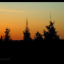

In [22]:
# Create the text tokens to feed to the model
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens = th.tensor([tokens] * batch_size, device = device),
    mask = th.tensor([mask] * batch_size, dtype = th.bool, device = device),
)

# Setup guidance function for CLIP model.
cond_fn = clip_model.cond_fn([prompt] * batch_size, guidance_scale)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options["image_size"], options["image_size"]),
    device = device,
    clip_denoised = True,
    progress = True,
    model_kwargs = model_kwargs,
    cond_fn = cond_fn,
)

model.del_cache()

# Show the Output
show_images(samples)

업샘플 - 결과물 중간 확인

  0%|          | 0/27 [00:00<?, ?it/s]

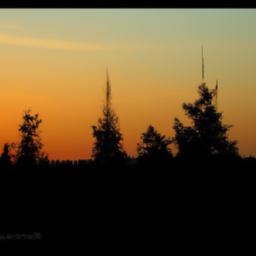

In [23]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res =((samples+1)*127.5).round()/127.5 -1,

    # Text tokens

    tokens = th.tensor(
        [tokens] * batch_size, device = device),
    mask = th.tensor(
        [mask] * batch_size,
        dtype = th.bool,
        device = device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise = th.randn(up_shape, device = device) * upsample_temp,
    device = device,
    clip_denoised = True,
    progress = True,
    model_kwargs = model_kwargs,
    cond_fn= None,
)[:batch_size]
model_up.del_cache()

#Show the Output
show_images(up_samples)

이미지를 저장합니다.

In [27]:
!mkdir project

mkdir: cannot create directory ‘project’: File exists


In [28]:
!mkdir project/result

In [29]:
#Tensor -> PIL이미지로 변환하여 저장 (pixel들의 batch로 변환)
def save_images(batch: th.Tensor):
        """ Display a batch of images inLine. """
        scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
        reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
        result_image = Image.fromarray(reshaped.numpy())
        result_image.save('/content/project/result/input.png', 'png')

save_images(up_samples)

스타일을 선택하세요
1. 고흐, 인상화
2. 뭉크, 절규
3. 피카소, 무채색
4. 우키요에
5. 피카소, 다채색

In [30]:
!mkdir project/style_images_ex

In [72]:
style_num = input("스타일 번호를 입력해주세요.")

스타일 번호를 입력해주세요.1


In [73]:
import urllib.request

if style_num=='1':
  url = "https://lh3.googleusercontent.com/fife/AAbDypAarC9awC98ZiuoJJ_UKGGu9AGSHLmn6ReweHKk_ddrstKVX05a8ajAtZwqBiQGBjtwyrDeRMi65iUi1Vz2_sC1E7w0e2wGaxMV81YR0Wqth-UxfsC4DdUItkP3oM88oRF5e-jKdq5FZkXc2VUniJVzXIUTZgMgeq4-hMlNdjJQIrkzsXEFghJ3awZH-_PTdxWHOfJ92BZJMAron2P88vF9haUkVZzZ7Vtiz0q8ZXYwT3b19l17S-vKC9nspdTMxCgUcFRCg4zNG21LtLhk9jMuu_4EAP32Y1lOFogZraY_JCLOgIWXPAE1t4cpjpx0wde93pzGMU2ZLNB2mFlkarFWulQBG2srT2zuf_r3VgXLm50di3tZtCHNHAob9FRZ6lZZQKjdG6xVOfWqCUfGXCBC4qFIy1up42jlu1-W-4hiicZVbYnUApeFVR90U9UA59bLJwKnD12c8K4Lak1Vw1uh6eWrwDkyAL_w03zQmBYJfTaKJQdE5iw-MhDYcXCWPlBXCjvfXlwicYcU8NXOgghjEgJDPFFtNxzXduhwxOf8uMzrGC7R_LrnX-C3w03OI1EQii6oCyly0DsbOTT0TKK5ckv06UQ39upiyo3blHhbi7PBzN__0G1w6vZ2dFBC768wQGrRL7QaRcu4Wx12GWBAYbA0zHit5jNLxt3ERwPXAvzEIgJAblhjA4s0E8EKUKjWe9wkGTW1NSf7xom7jKJHlHsb4FDxs_5L7nbF0aupyLUr5gjxb46KxWVBmDy5Ih2-X3BvpfjiGfBq1nC2wGHw2mJqWLrthsM-uIN7F71hAWQqYWKibwkTn6oTfsgGWlQoQ43Pg7w3rPb0ficuMzseUwWg55D_NKnf2SeGYkPE5OClNDBOKU3aELywQ_iJBkFX4EtayFO7zIDXg5NVuGzSmc19WV3H9KfbyttZHmtjXmmrxz_0nZNCe_mMIOMT2aRwYUH-WPO3dLJHxicmIxIeeNP6_H9VXUzuaOZKhkOJCH1tOpS5VupjUBTaaCzlGDbPCfV0MJkpZX7cTPdOPNQpT4LKj4lBAtxCQ1roagIvSgxu7lED7PB840w_QrPyGlps9FV25ZFwGcs9O8nmZvfjE-Quo2bsonONAI7hn8dAXL_YXIVupHBZjo2hK2-dnTsLS6WY_1R8njm6XWVj-N2R0K0x09d5xALQ-UlCcBk4vM6cvwylz598ZbrBtKFdgFxeSWYFYsYvHvqtPk0UkF31a6vXKH61oJ2XNHEQo8qZZw0wRe8jfUn9_kaFCTof4w3m7crtrTdhl79RZ2Rd3jPdD8cNUZwX5wXgbqjxZEGmIIQXaRkU2IGM7ec8NsvOF8Mubw61gKXVJ74ao5Y7O0KgmKYXKkjed9cF9KUp62XWaXLJ0AZnMNGOybJ2hIRHCz1IWhv1NRcQDU0jj0mLw7Y-wwX6xU5_kdxSuyl7sD_3vxW_bU_F6gg47oPcnaqSUODPwEfWGQ6si_WXdhUx7xgS3dhBan09eS7_pAzryqIIWgu6gZ2Qufofb0Y=w1600-h732"
elif style_num=='2':
  url = "https://lh3.googleusercontent.com/fife/AAbDypD7X-LzFGZMKcgcoizs9AvTq8n9Fk7Xmx_u1NMrkwQHfGaeM7hU4Kj_p2j4ew3HhzucqonEj4K9dvsrf6-i9shImVcL9ib13ebD5SUhO0fy8yO8SRPQ7xaX16lhxWl3rmfMeV-O0lX7lEGJY0g2DJD_lHt-Ons-hI4whsc-sKCokz3ENUtRKxxgRPri8N9FUm2gmeF9Nsms-IpuCk0GLADfwFFINP-4WIPllU_V8aLMzStvMCX7zrQGv4O0_yHaEALfqrVSOJNKX4Xv9hFaeFRELKBwpwDLyFSczQwQMu11cy4JW_bMetFMJ8QfspOYfpUOE_AK5Yxndkj8Nxp6Hs-YF2YsSWXdhjZPFgHunL0r6UYYBtaCeOU0RivzafRn4km5itVmr8403lCojjPbz8NBiEVVm8JySUz3O2_EL4cQXpwJVN5UgIAzJNUTidcSmDPY20rRmjjLKw73TL1yQHeHucFZFIbr930u07bZSry5PiTdzbBMyzFByoGSqKcEknnaPNcSUMu6EEt360o2XTEFE5eyF2iofbPFhhmokQ4UxozX9-A02kikC0bub1-nvN9Tyr979HWPa-VOMeVhEc0iZW7mih2uFQctkYQ1CQqr2bMX6PIHC9yYwpJCrIJnlfcryCeGXOZSVkTvWwLeCfFfxMzJuWixpCfL7Rwdq9QVC1UOLRpeFX295i05c4D52UvhbE3kD1coywuA3HWAa9IMhjSKIgOlNmFLOUc4KpKSJuOqmQpuIbNym_GrJmAXcVrgPWU6HlLTnkE4v6YXGOYqxigXJ0r0BJ4PIH5gBaac4qRlzytQZQ1G26OoUk82x-HnyX7MFUfuyPISiID6MpTPP2up6j622cqgl0oiFMd23iyEC3sVnB0845VQOATcVoH1euAAiz5JAnBFEN1x9EvWQ0Y85ni5elA5pQ2HRgFFZLRIm2FezUr2sUtyFg9XA8e2-jhzzzLx4wLx2dMNDm7V0n_6ha5v0imwnB-_6wSNucMuZvdUz1vyVg0LmDNeSjm0O8tQ5eUrv7nWO8AwUzH06u_S2lzGkS7mWU-tij2C9vvqexCBmTOmnHS5ZwRE0i97Rq5PeFO5cEyGhfF_Y493yTuQjUrkTazVhG7_Fl0jHT5mpiCmwgVEiAUfScUezXEXv56ImHeIbvXo3AGoblpY0yMMfHBQmynhZuFeKW54wPeqKKT6juT_as6w57CKTBqfY5lHjf_iex73gd2ea7xR6TyzS6W9W0bMc0UsjrCcLBffevjJo9iLrpk3iiVSvzJzGDpRI5khXBujSSg-F6lrtSEz8bHibRYGSmZtsoYduzSyXF6gK2EgH4ISea0G5NPCbMc9Q2myMXu7Us1oECQLDVWbPmr96tj2mIpVbERIMd_nDxfV0hpVU3FT5SUil5inY9uBQ-T7hQfwRm7-4oyIkZPwMrmVN8NnrdN0wjE8bAg_Mhv4OvZfkL1okPqdB4zcHNbiMbQP_WQofobEZn7Rw3J2S4-laZ3dSZrIgjns_dR2r9HLkSzxurU=w1045-h732"
elif style_num=='3':
  url = "https://lh3.googleusercontent.com/fife/AAbDypC1OagBuzUoJMAWv9uMZym1Vn7wUDMYoxTOSdKm1zbVTu6QQNR5I7-6I7UmLc5faLvg2OIrxeBMBtHEnfeYNy67hkX10U-JuboRCZE-VqDeikAvYNa44k6oMhUnKKauhTquLEf0Q4EMzLv8hcw2FFOtr1wCDtvv8-qJcsB-RjvyBC_AVBJ0yywCQVwEYJM1V1fUxg_YfuTifyRQ7CFy6B6-QdeJzeYtYqDqlqdkGfQzNCGFNuVvS9PCoVWbDsnlxzdC8KCkOF1eigcpjiMqdRLigI3xQ4C5YkFUfVdeZT9hsqZbB5gwBTtnC6Hq2avi5t8sgF1SqqlWARBdqxV-grocl4g_wkHof6YFrZUPs-amUcQNkvt2xcbapympwMbGxsfadkV4fdJIn7DwKw6Ubp3GsK65hfu4fWMXQOyBFRI6wJM8Nu0Givrej6S9iwObSJ4koia74LfDNhKE5qQGBhmuO4_WmOYyBfFx9Kz7OGgjonbyezhpoZE2HsZtcQ2IZbmv7noMGFYOjWaEWNnCE2IuiUE-GWWRtWdiNr2s3quKn3WRVjBFNtofw50Uxt93r8ndPjs4oVPGV5wFhI_xV_IBBOvNUtVEwhpWYsdSYaXEL7gbeU0ii-DvTxH6yv9I6GAJmQ0hO20I0-5GInErzIYCHWNWQ4-YXH2_L8A-_SNfuC5nGz4e2hMbkNZJHmPB5nlJ0N2vWgR41R2weFkvrO_xh2p8te1p0vV4sQPyoAjJonlu2LnCq01nzlsIqfuddQYbB9ub9mQWxgm6XqaZzcZBnrpjuPdEUDBsABN_g-1c5twHT4MXj3KhEtmVgEy8Jnw3kZjm4HsRXEsngIZwNDrJESS8XkVEOU2C2Lfw86yGJtRThhjdPiDwMKwFVNi1O_35dhnFUwK-JPag7vcoJIhIQpXugEfMSGfGos5ajx6-eoBfHx2p5UhK-q90Nf3wHv5Ws3wgku7nVS8PK32piF1pNnJjH0zoBtP7jzkQ15yVADSXfQDES9w3pWM510K7ELMH3C1MCOjKGScZHAzCP556yzLuasClni-qJ_3XopbkdIcrXZeS9PeBq3Z8xkrC_z57FhLDTMNwgSQ86L_25Y_PiAENhdv3YQhTgT2svD8vHEUvxVpsbrnUOdbiYwdWTJ0DlbM2wf8BBwKsWpHAmM61sE3bJUonSX3LxXhfK3PIUUaY8mvbuZ5gWJu6Ip1SC7TdlMDQCzG1cFR0QNmF6QaRk55fpYAyMRHfVizhOV6tT3hPpJ5DNtomG1zHzXlU9LSGJY_uRq_APyqp8UDr3xyVbcWZcfdUQdJ61hRyIsxyVCXp_V4Heb8PUnatMT-o7HRffJsWD-1rQxVN0c_WFmHK39hLQfwQZyoy_8LXM8h0Z0Vf9Hk0wnokumgJltxDn_uYH1KqBS1rYvpw23vx7THBLuQMiOghkIt2eUkbeH3GAzLHBiNXghmc0UaeiMRH6SYiAp_xb8zN-PhHKnceNPdjofsYaZEvqE591Y37ZK7xhqSRWNHiRfYj3tw=w1045-h732"
elif style_num=='4':
  url = "https://lh3.googleusercontent.com/fife/AAbDypCRdNwV1_xznDzyYUbnTC5g0iziKxMfPHedskl54l4RRrC5nI90AxMHa3tgytpqy2N0-_5wr8b-Nf1ELV-IFq9stn718sFaHwvXn5tcMuQhP4-N8pDsX6H-ECZXRER-TnhnqYebdGcrmKTVQvxs4sH0nQwrTLf3ZpERm6Py8x-UaYlNRXxLQrynwt7Nzw8IcYUPA245wJUBHDKUvDDVHXVA67VWqRskspZVKeuF5bGodkoZr54int6lH-6zuqGQEy3g1TgXy3qnzqVrHweydS7Kf_ZCfy2kerg1kzATTc8QJWlhZXagzuOyS9zDPbx1IWKt0QumiQu7ED5S_z92Hu33fDxLXqjj55UI9OmZPSDTe2pWeMN1VENZLv-_W_49op-7FkKfP6jDHwLzedH2siU3aCy1NS9rTZvcdUR-oqwMxx4xkqbjvMUhclepIdTppCQYUy5lWWVtDUpGL1FDeJw7DP1567rAVKIdzbbD-HN-sKmgjqI4OFZhSc7-Ti-42rqgxQRmaVPXjHZ1bp3CYTxzp0zk6iwtIVO0nzLAylVQR_JZ_Dd0tls1vwx_SP1ullHyFBrA9Y41ofn-KXtd0JvsVEUD93WCnLveRtsYRdDInX2nz3hig9jh0ZfvUOWhRWUytvxASldafpGVw8WsDh_Wj0lOeWtxFHTdSrAPaKng683qmpQAeb8cXhadaQtrbJmemEeGxqJyeDUR2JDgpzsC2X1TZKHmxg9cEnXyrCWw_pvxbpAznwnIJS6RTSMl3rwbA-IXBPcPI6-TiHNyqvtmmOGycPBfpLl-tbXzn3jN949YV9q5x2iDWHJ2BKMAy1v_BErazp1hU_D4LcsLBCI6pHvaQTJhdBeHIbxbEaSjXpogtQSpfdXZm0Xu8F0xt4ahT8ccYeY4lwyB9YUCaUb1i3tm5quwxWJLGGKmmFCQgwvkpyi3KEGu4M14adPvmAQvXzfHPwdN1DMVSyA0038w9UqtBS-tKz9NBmV_Y7hVN1g8ua2cwyJTvssP2wmYBZR3ICi6A_E2QM3vopmjv12_biOa1xWaREH3dpVWcpRZXBJHNDctzInf1-NwHr0LrwZZTqBZFJAvUfxBEra-N77ApQ-LnBCKdZj-8TO8q_BFDkvYl0jxLgUrPd_zeg6a2-3Dn378ualk7zizApQlNPTMriLaj8HpXoCLYSOoYuC1T1jl6oH8G6bnmtKuLUnlb5LkiVRNj0PgE_LbgNATgvIdyEruRotc6yEyHpwiYrY-dtpnqltetwZS0ZDmpfuYt5gmf1xHDio1O3K3bfyn-f73pZIuLL9b9bUxomy1RPy4jtFi6ieuwO2bVe3lnkVKhUY2i24IUZkdo4xM3lLTWhd85-rfGIyo894ozphWfH8WDMqz1GO_zT_pLIjvmGsI7xoE4voQ7Zl3zSOrltoFZaeJWTJw_sbp4yImUjRpyemtN4ut4WT9sXNHRuiGV0cTHc3gnzuhhkLxNNRtc2ufnYxUiW3xJkB233KLMiof_OHqo70lB0ZWKqlmNw4=w1600-h732"
elif style_num=='5':
  url = "https://lh3.googleusercontent.com/fife/AAbDypDDN0CsxUASo83-1qcW0qtGY429h_XcMdJLbYrZENc-EqapYKTj2Al2bJLWTac8ymMc3cs1xfYXeF2oBrWgcG1qu5WsljPBGkuI8FC9Ni1gge15xm9TCQHIyyI4uVdCo4yEix6DyS-v7vtyhWICjn96s1Rxu1G4GfyyUrY16UK1aglCyIC8K2NTLGgaIRT60tZOLb4ySe5rHBVj8Q9sc0aj_4PUZ-c4gmC0OgLAujWx_7uX_GrBOmX93RVnQ5F2iBnPTPiyCUjrcf6q9ytNd8GnALHtuEJsFLl5ODRrSei_n0gjXGCu8W0eAxPBcX72sR5lGYJ-uMENRnRnm-iJcJDpGh_Ca_AWdtNgeMNA0TJh9HEj_83P1pdS0r3nPPpP8CNA9AOXNW3tafDaEFamT_hR5PgfuRELn52k6YzHYw8pkArLeHO_dTV3JNn3iFMi6g0ivmyGVR52N87cAVkaKkX-dFQkgLhWEjCedVoyGqc2KH6Gu-TUg1vBLvSwVofzqbFttF_ELJI7dOYOBCkslGnGI52P1AVUvt8iGQ4HXgPCKsv8bvho7UO8A9NCoY22TdjlAMkJ4VF_tFTdj0k_4ktLdaz8JqkkS1k8SVSGbki4nMldRhrNsxBtV8Gw1jWbksTTNommXyopJNyhv4RtMZ15UfSE_hARhHjIAAq6hl50GiKhej4eyXpDZkUuQHYEZHBAH4tdbPYtKwzAyoHNQJaL_T5EdMXdJw-MKUkFPG47SddedzXiyoXy00XUW1uzgfdSejKxxCsKDKv8FrOOzp2h_TZTRkx7EufuNo1XS74Mvr4pUfvsmcRnHSDiMBK-TLxwpC0ggQRQSpZaCS9ro6PCp9hO8Nw_10NvEgyMWqSqQHxjADuCLz3R7dodlEC8N89GnswhNBhSyn3G6qM3oN_cF028ySrAbm1gQF3jombLuhPR-GcXey2YcWhgjCtQg_g7SUGs_hBSPBV10upLQ8ejlFVzL3AAYn3T02EZn-OkuHndYc2-84_ml13DnG_zuJm2o-JWx53xLc7Cve7zkKucKTAmr4hcKmM_vrL1ELCy1m6kts6nA4L0i3Wt7JQyilCWate42UCPgHflDB9h1XtZL2jbEkBRDEe5NF8zndNXfyxd2mC5SNWMLOUgSG5tMzO6hEYhrvYLD4MrmL_xv_ropR0odxpwCXCPOyIRIcIFdpLlF9kCClIkjx4KmeW1CJY9jZyhCQdKJdpmamhMm_ZgL0xhxDgAXeyXXVVvrgwPJ4Sakb-kCq5F3fbTTMWqq_X0rsNyQBehIXObqV8JGv04xcm-uDW1ImTt0lDNy_eag5OdgOM6e2IfQzliZOGVyNvVuA9Frk9K0wnWe5kml7FZmI7W-2-YwdIvVqkBl5L4sQWZK8bzFMfVTQjX6j4Rlqyu1yypk0t8B6Nv59kBHADlXrskG7hl_WpqO6IKx8C5IK2UqoHbquoIaiqdW2Sm5DkA1W4j1RgcTmZfeYLf2xn7XOp2rUlIi0XeI07L9CaZDnwCw7RO3TrXXtE=w1139-h605"

savename = "./result.jpg"

image = urllib.request.urlopen(url).read()

with open(savename, mode="wb") as f:
  f.write(image)
  print("저장됨")

저장됨


결과물 리사이즈+ 스타일 이미지 input (크기조절용, 4번 선택시엔 실행 X)

In [69]:
ori_style_img = cv2.imread("/content/result.jpg")
style_img = cv2.resize(ori_style_img,(64,64))
cv2.imwrite('/content/style_img.png', style_img)

True

In [75]:
# desired size of the output image
imsize = 512 if th.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, th.float)


content_img = image_loader('/content/project/result/input.png')
style_img = image_loader('/content/style_img.png')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

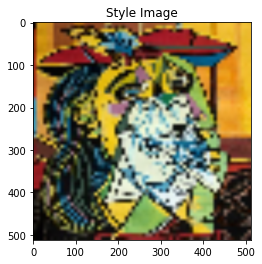

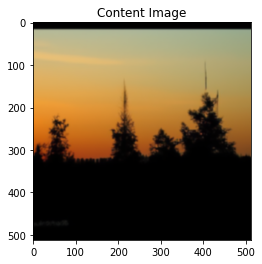

In [76]:
#두 이미지 잠시 확인
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

내용물 이미지 재확인(오류 확인용)

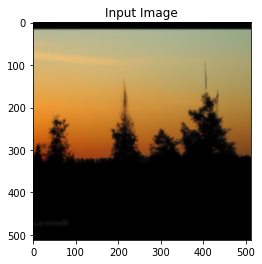

In [77]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

최종 결과 생성

Building the style transfer model..
Optimizing..


<ipython-input-17-30ad8c495860>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = th.tensor(mean).view(-1, 1, 1)
<ipython-input-17-30ad8c495860>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = th.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 1.996714 Content Loss: 13.114389

run [100]:
Style Loss : 1.751675 Content Loss: 12.880745

run [150]:
Style Loss : 1.477502 Content Loss: 12.709816

run [200]:
Style Loss : 1.258037 Content Loss: 12.591809

run [250]:
Style Loss : 1.134897 Content Loss: 12.484892

run [300]:
Style Loss : 1.026136 Content Loss: 12.403127



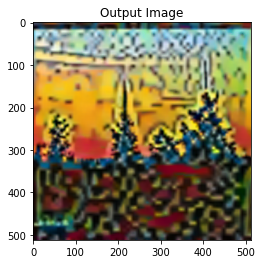

In [79]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()